# AfSIS Soil Chemistry Dataset - Modelling¶



## 1. Load libraries and data

In [42]:
import pandas as pd

#from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.ensemble import  RandomForestRegressor, AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model.ridge import RidgeCV
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import svm
import numpy as np
import time
import statsmodels as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from IPython.display import Image


from scipy.optimize import minimize
from __future__ import division
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.neighbors import KNeighborsRegressor

In [2]:
df_composition = pd.read_csv('complete_elemental_analysis_dataset.csv')
df_composition.head()

,SSN,pH,%N,%C,C % Inorg,C % Org,Am Ox_Al mg/kg,Am Ox-Fe mg/kg,AmOx-Mn/mg/kg,AmOx-Pmg/kg,...,Fe,Mn,Mo,Public,Latitude,Longitude,Cluster,Plot,Depth,Cultivated
0,icr006454,7.85,0.08,0.95,0.0,0.94,2105.973713,868.347797,160.462825,27.456545,...,1.16865,0.02010,0.01845,True,-6.12601,36.440201,1,1,top,True
1,icr006455,8.03,0.06,0.81,0.1,0.70,2703.686191,1095.670284,185.252606,48.309930,...,1.59154,0.02566,0.01845,True,-6.12601,36.440201,1,1,sub,True
2,icr006474,5.01,0.05,0.57,0.0,0.57,1554.842158,949.235199,52.608644,22.887339,...,0.88799,0.00792,0.01845,True,-6.08875,36.435982,2,1,top,False
3,icr006475,4.57,0.05,0.47,0.0,0.47,1846.889773,1070.019199,33.656658,9.381672,...,1.25013,0.00819,0.01845,True,-6.08875,36.435982,2,1,sub,False
4,icr006492,6.78,0.09,0.98,0.0,0.98,1871.559305,1204.912035,172.634574,32.109882,...,1.48940,0.01938,0.01845,True,-6.06394,36.440500,3,1,top,False


## 2. Elemental analysis and soil fertility

### 2.1 variables correlation

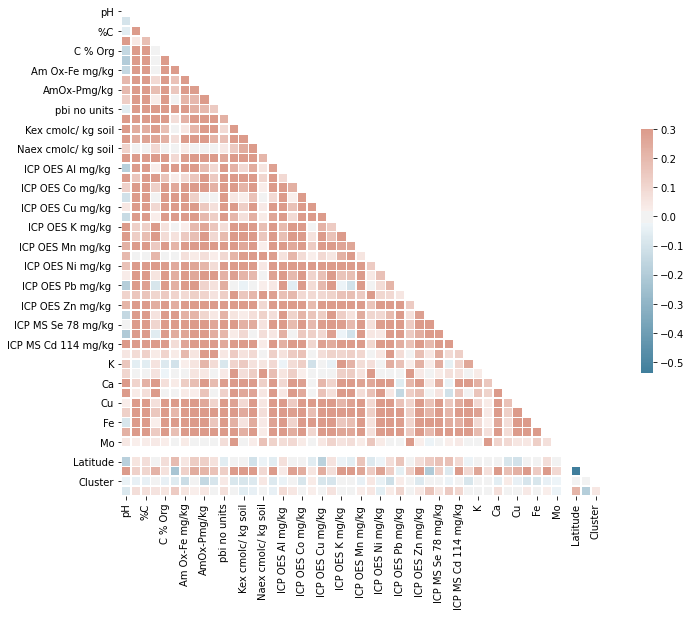

In [3]:
# Compute the correlation matrix
corr = df_composition.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The figures show poor correlation. Surprising that this is true comparing the same element concentration estimated using ICP Optical Emission Spectrometry (ICP-OES-K) and X-rays fluorescence (K)

### 2.2 Composition - fertility correlation

#### 2.2.1 Features selection

In [4]:
elemental_variables = ['pH', '%N', 'P', 'K', 'Ca','Cu','Fe', 'Mo', 'Depth', 'Cultivated']

df_composition_reduced = df_composition[elemental_variables]
df_composition_reduced = df_composition_reduced.rename(columns={"P": "%P", "K": "%K","Ca": "%Ca", "Cu": "%Cu", "Fe": "%Fe", "Mo": "%Mo"})
df_composition_reduced.head()

,pH,%N,%P,%K,%Ca,%Cu,%Fe,%Mo,Depth,Cultivated
0,7.85,0.08,0.00506,1.59260,0.44832,0.00098,1.16865,0.01845,top,True
1,8.03,0.06,0.00506,2.04214,0.90155,0.00124,1.59154,0.01845,sub,True
2,5.01,0.05,0.00506,1.28172,0.08998,0.00093,0.88799,0.01845,top,False
3,4.57,0.05,0.00506,1.29913,0.09441,0.00130,1.25013,0.01845,sub,False
4,6.78,0.09,0.00506,2.21456,0.76517,0.00144,1.48940,0.01845,top,False


#### 2.2.2 Categorical features encoding

In [5]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(sparse=False)# label encoded values of depth
enc_df = pd.DataFrame(enc.fit_transform(df_composition_reduced[['Depth']]), columns = ['depth_sub','depth_top'])

df_composition_reduced = pd.merge(df_composition_reduced, enc_df, left_index=True, right_index=True)
df_composition_reduced = df_composition_reduced.reset_index(drop = True)


In [6]:
df_composition_cultivated  = df_composition_reduced[df_composition_reduced['Cultivated'] != "unknown"]  # eliminate unknown values
print(df_composition_cultivated['Cultivated'].unique())

['True' 'False']


In [7]:
# creating instance of labelencoder for the column "Cultivated"
labelencoder = LabelEncoder()# Assigning numerical values and storing in another column
df_composition_cultivated['Cultivated_n'] = labelencoder.fit_transform(df_composition_cultivated['Cultivated'])

print(df_composition_cultivated.shape)
df_composition_cultivated = df_composition_cultivated.drop(['Depth', 'Cultivated'], axis = 1)

(148, 13)


<ipython-input-7-d4eb68b28776>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_composition_cultivated['Cultivated_n'] = labelencoder.fit_transform(df_composition_cultivated['Cultivated'])


In [8]:
df_composition_cultivated.head()

,pH,%N,%P,%K,%Ca,%Cu,%Fe,%Mo,depth_sub,depth_top,Cultivated_n
0,7.85,0.08,0.00506,1.59260,0.44832,0.00098,1.16865,0.01845,0.0,1.0,1
1,8.03,0.06,0.00506,2.04214,0.90155,0.00124,1.59154,0.01845,1.0,0.0,1
2,5.01,0.05,0.00506,1.28172,0.08998,0.00093,0.88799,0.01845,0.0,1.0,0
3,4.57,0.05,0.00506,1.29913,0.09441,0.00130,1.25013,0.01845,1.0,0.0,0
4,6.78,0.09,0.00506,2.21456,0.76517,0.00144,1.48940,0.01845,0.0,1.0,0


#### 2.2.3 Data modeling - logistic regression

In [36]:

X_cultivated = df_composition_cultivated.drop(['Cultivated_n'], axis = 1).values[:, 1:]
from sklearn.preprocessing import StandardScaler
X_cult_scaled = StandardScaler().fit_transform(X_cultivated) # scale those features
y_cultivated = df_composition_cultivated['Cultivated_n'].values

X1_train, X1_test, y1_train, y1_test = train_test_split(X_cult_scaled, y_cultivated, test_size = 0.2, random_state = 42)

In [40]:
lr_cultivated = LogisticRegression(solver='liblinear',dual=True, random_state=42)

lr_cultivated.fit(X1_train, y1_train)
y1_pred = regr.predict(X1_test) # estimation of cultivated value based on fit
accuracy_lr = regr.score(X1_test, y1_test)
print('Score of the logistic regression model for soil composition and fertility = ',np.round(accuracy_lr,2))

Score of the logistic regression model for soil composition and fertility =  0.83


/home/marco/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [41]:
cm1 = confusion_matrix(y1_test, y1_pred)

print(classification_report(y1_test, y1_pred))

df_confusionmatrix1 = pd.DataFrame(data=cm1, index=["actual negative","actual positive"], columns=["predicted negative","predicted positive"])
df_confusionmatrix1 


              precision    recall  f1-score   support

           0       0.86      0.96      0.91        25
           1       0.50      0.20      0.29         5

    accuracy                           0.83        30
   macro avg       0.68      0.58      0.60        30
weighted avg       0.80      0.83      0.80        30



,predicted negative,predicted positive
actual negative,24,1
actual positive,4,1


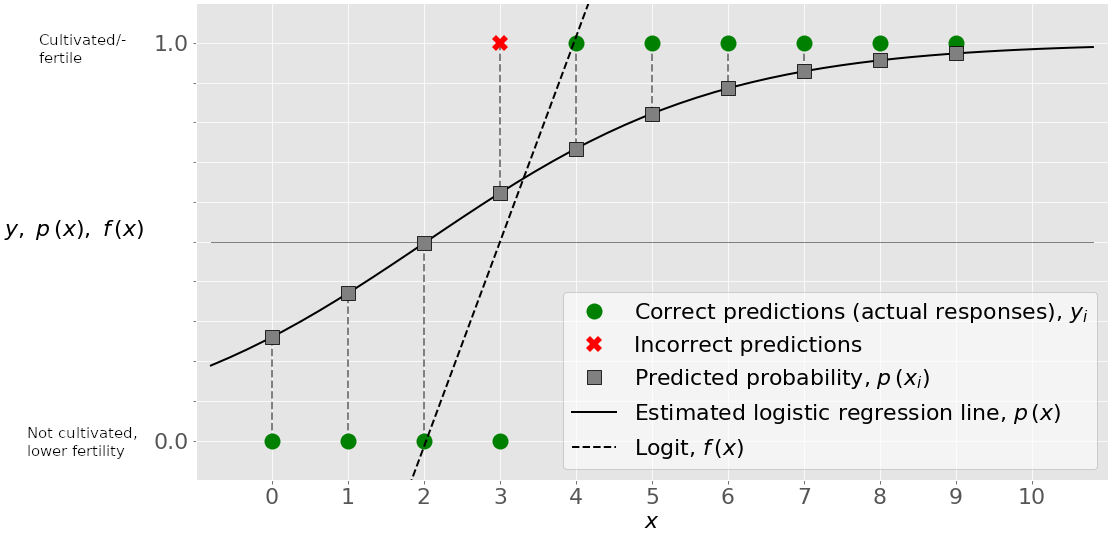

In [43]:
Image(filename='img/logisticregression.png') 